In [87]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.utils import save_image



In [ ]:
# scale back image
def scale_image(img):
    out = (img + 1) /2
    return out


In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d, nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
# for shapes and more see
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

# for architercture refer to paper https://arxiv.org/pdf/1511.06434.pdf

In [88]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        # Input: N x channels_img x 64 x 64
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=5, stride=2, padding=2
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 5, 2, 2),  # 16x16
            self._block(features_d * 2, features_d * 4, 5, 2, 2),  # 8x8
            self._block(features_d * 4, features_d * 8, 5, 2, 2),  # 4x4
            nn.Flatten(),  # 1x1
            nn.Linear(features_d * 8*4*4,1),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,  # because we are using batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [ ]:
N, in_channels, H, W = 8, 3, 64, 64
z_dim = 100
x = torch.randn((N, in_channels, H, W))
disc = Discriminator(in_channels, 8)
initialize_weights(disc)
print("Discriminator output shape:")
print(disc(x).shape)

Discriminator output shape:
torch.Size([8, 1])


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        # Input: N x z_dim x 1 x 1
        # Reshape it in forward to N x _ x 4 x 4

        self.dense = nn.Linear(z_dim, features_g * 16 * 4 * 4) # 
        self.gen = nn.Sequential(
            self._block(features_g * 16, features_g * 8, 5, 2, 2, 1),  # 8x8
            self._block(features_g * 8, features_g * 4, 5, 2, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 5, 2, 2, 1),  # 32x32
            nn.ConvTranspose2d(
                features_g * 2,
                channels_img,
                kernel_size=5,
                stride=2,
                padding=2,
                output_padding=1,
            ),  # 64x64
            nn.Tanh(),  # [-1, 1]
        )

    def _block(
        self, in_channels, out_channels, kernel_size, stride, padding, output_padding
    ):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding,
                bias=False,  # because we are using batch norm
            ),
            
            
        )

    def forward(self, x):
        x = self.dense(x)
        x = x.view(x.size(0),-1,4,4)
        return self.gen(x)


In [ ]:
# hyperparameters
#NOTE: according to the paper DCGAN is sensible to hyperparameters 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64


In [ ]:

transformation  = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [ ]:

dataset = datasets.MNIST(root="/dataset", train=True, transform=transformation, download=True)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


In [89]:

# instantiate both models
generator = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)


In [90]:
# init weights
initialize_weights(generator)
initialize_weights(discriminator)

In [ ]:
# set mode to train, redundant here
generator.train()
discriminator.train()


In [92]:
# optimizer and loss, maybe BCEWithLogits is better here
opt_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [ ]:
fixed_noise = torch.randn(32, Z_DIM).to(device)


In [ ]:
# create a folder to store generated images
# didnt store now will try later
import os
if not os.path.exists("gan_images"):
    os.makedirs('gan_images')


In [ ]:
# to plot during training
def plot_images(images, batch_size=128, cols=5, rows=5):
    fig = plt.figure(figsize=(8, 8))
    imgs = images.cpu().detach().reshape(-1, 64, 64)
    for i in range(1, columns*rows +1):
        idx = np.random.randint(batch_size)
        img = imgs[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
    plt.show()
    


Epoch [1/5] Batch 0/469                   Loss D: 0.6941, loss G: 0.8282


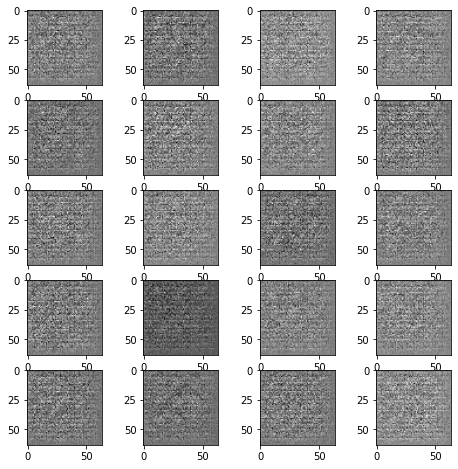

Epoch [1/5] Batch 100/469                   Loss D: 0.4807, loss G: 2.3302


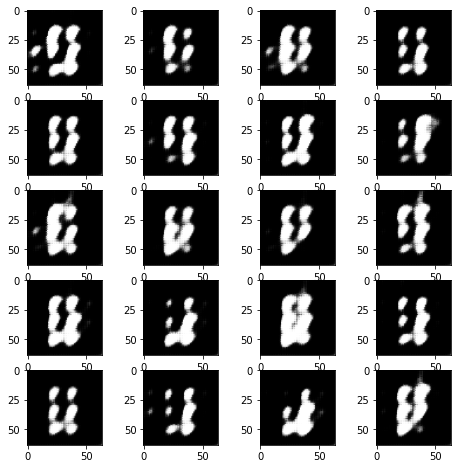

Epoch [1/5] Batch 200/469                   Loss D: 0.5056, loss G: 1.8476


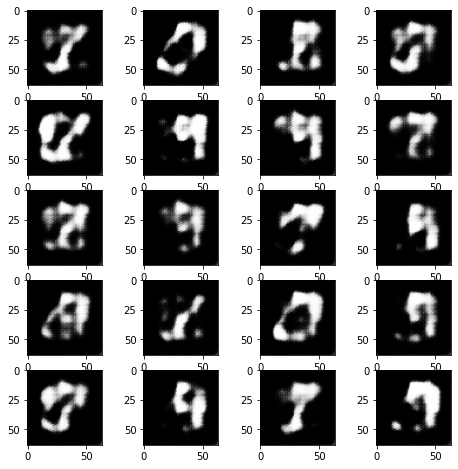

Epoch [1/5] Batch 300/469                   Loss D: 0.4263, loss G: 1.1575


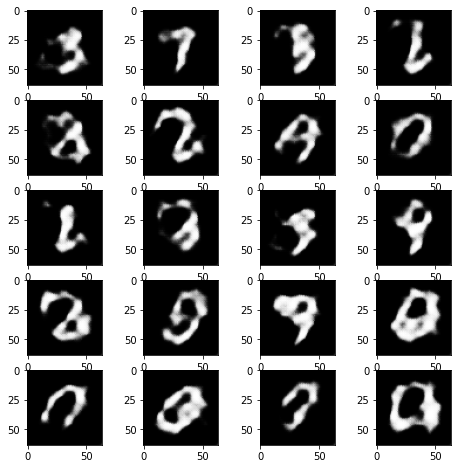

Epoch [1/5] Batch 400/469                   Loss D: 0.6116, loss G: 0.9493


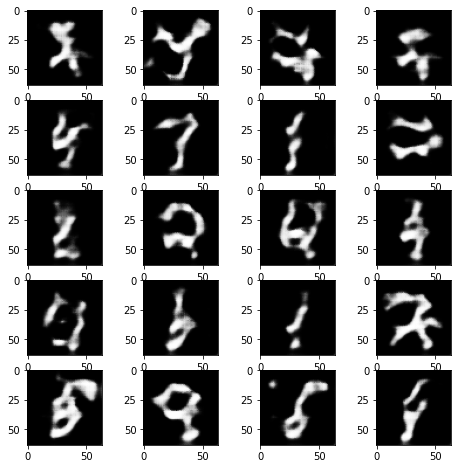

Epoch [2/5] Batch 0/469                   Loss D: 0.4128, loss G: 1.2788


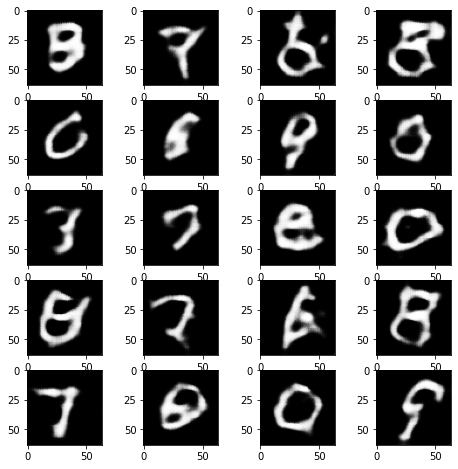

Epoch [2/5] Batch 100/469                   Loss D: 0.4926, loss G: 1.2242


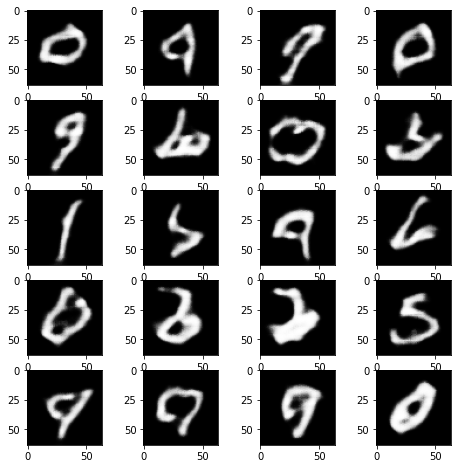

Epoch [2/5] Batch 200/469                   Loss D: 0.2299, loss G: 2.5648


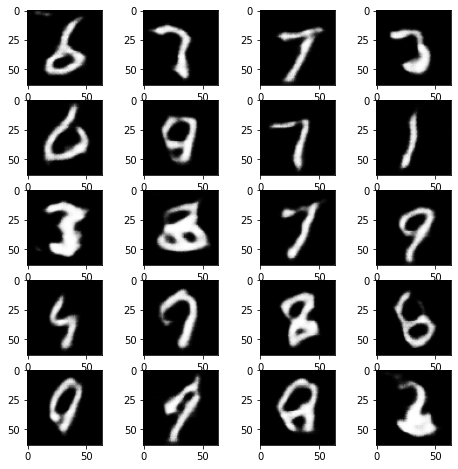

Epoch [2/5] Batch 300/469                   Loss D: 0.2579, loss G: 2.1037


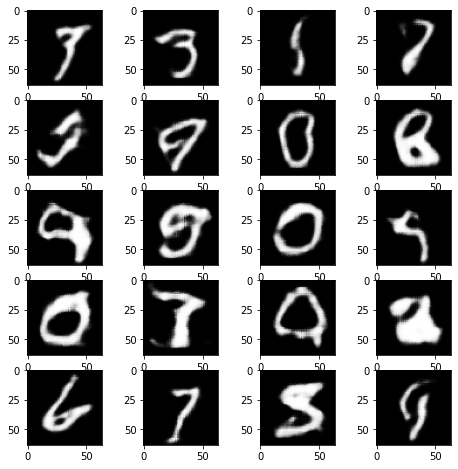

Epoch [2/5] Batch 400/469                   Loss D: 0.2875, loss G: 1.0744


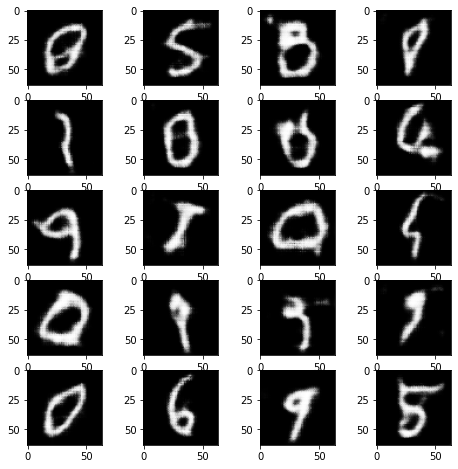

Epoch [3/5] Batch 0/469                   Loss D: 0.3386, loss G: 1.5072


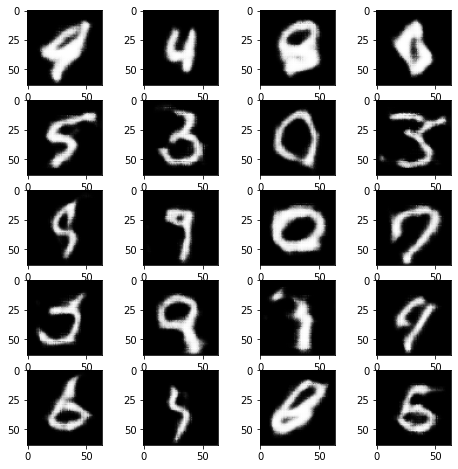

Epoch [3/5] Batch 100/469                   Loss D: 0.1529, loss G: 2.6182


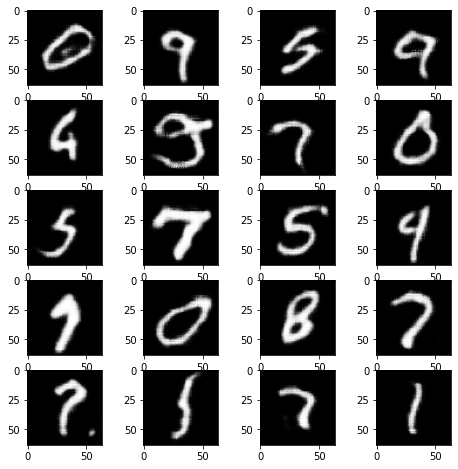

Epoch [3/5] Batch 200/469                   Loss D: 0.1119, loss G: 2.6011


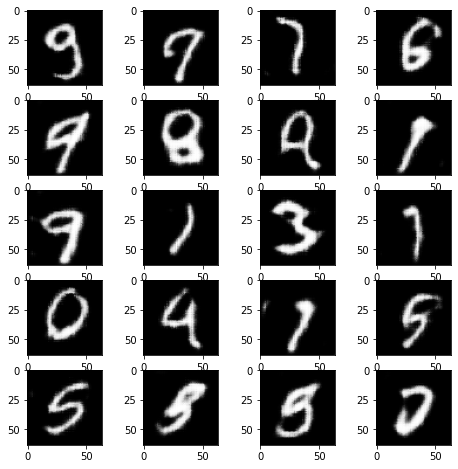

Epoch [3/5] Batch 300/469                   Loss D: 0.0980, loss G: 5.3208


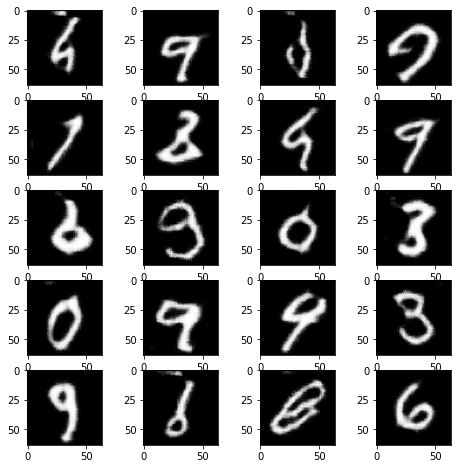

Epoch [3/5] Batch 400/469                   Loss D: 0.1587, loss G: 3.3235


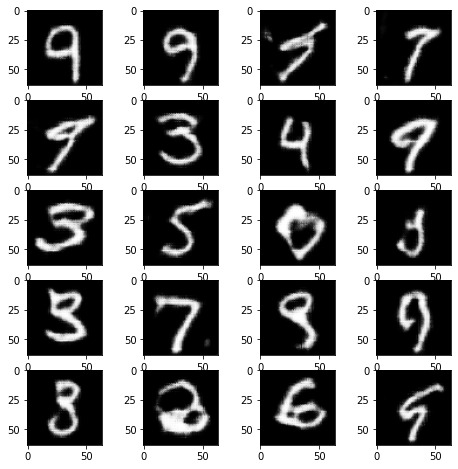

Epoch [4/5] Batch 0/469                   Loss D: 0.0871, loss G: 3.0610


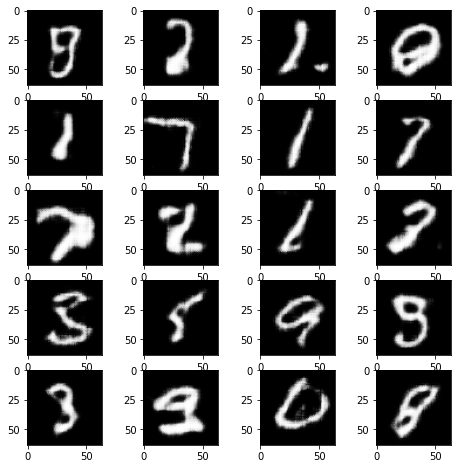

Epoch [4/5] Batch 100/469                   Loss D: 0.0343, loss G: 5.0298


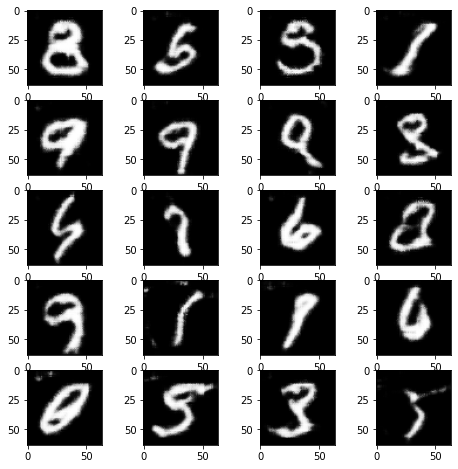

Epoch [4/5] Batch 200/469                   Loss D: 0.2760, loss G: 3.3869


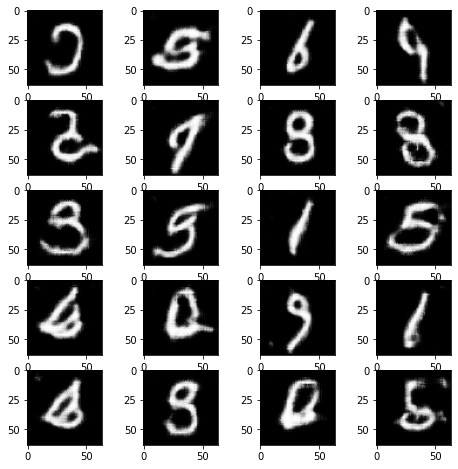

Epoch [4/5] Batch 300/469                   Loss D: 0.0488, loss G: 3.4740


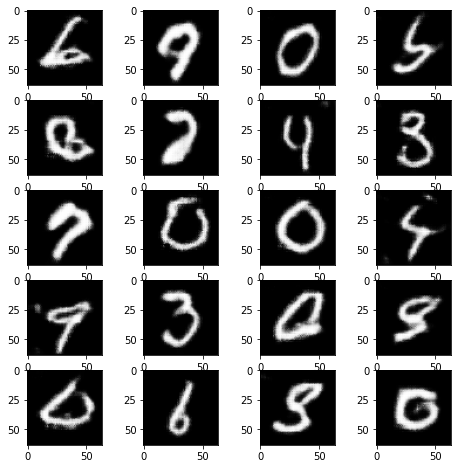

Epoch [4/5] Batch 400/469                   Loss D: 0.0172, loss G: 4.6436


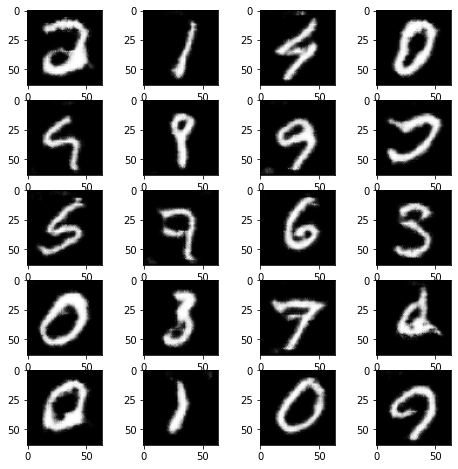

Epoch [5/5] Batch 0/469                   Loss D: 0.5051, loss G: 1.0327


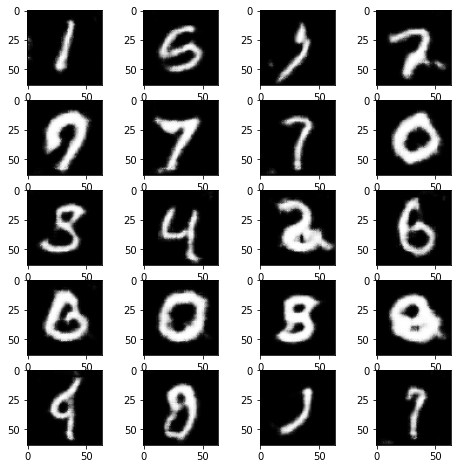

Epoch [5/5] Batch 100/469                   Loss D: 0.1465, loss G: 3.2273


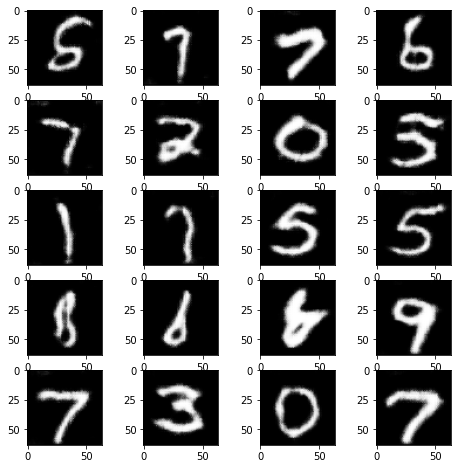

Epoch [5/5] Batch 200/469                   Loss D: 0.0304, loss G: 4.1002


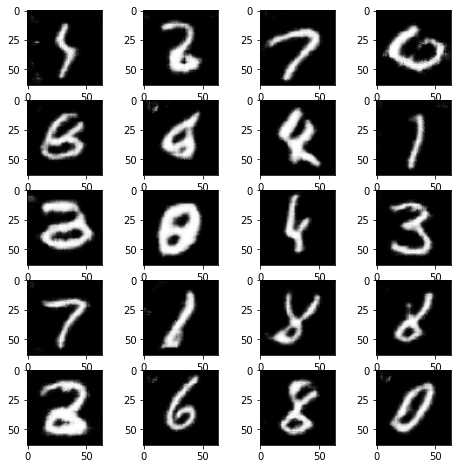

Epoch [5/5] Batch 300/469                   Loss D: 0.0204, loss G: 4.1446


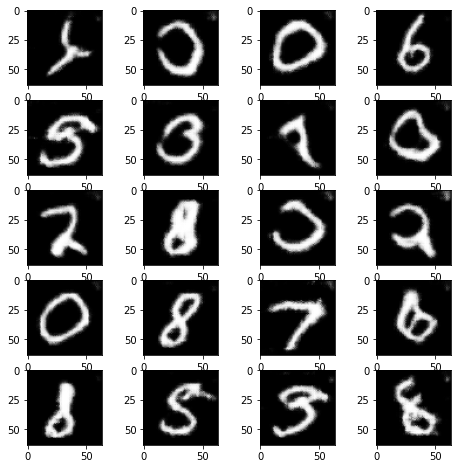

Epoch [5/5] Batch 400/469                   Loss D: 0.0274, loss G: 3.6168


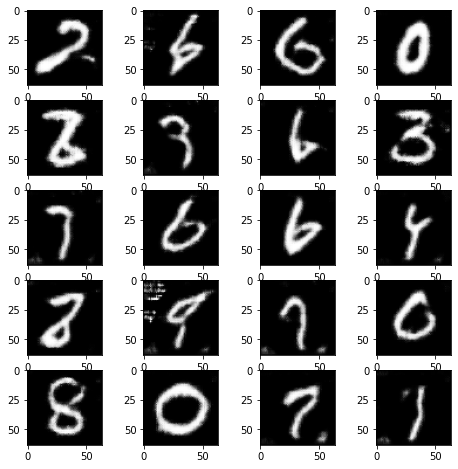

In [93]:
for epoch in range(NUM_EPOCHS):
    
    for idx, (inputs, _) in enumerate(loader):
        inputs = inputs.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM)).to(device)


        ### Train Discriminator
        ## get fake images
        fakes = generator(noise)
        
        outputs_real = discriminator(inputs).view(-1)
        outputs_fake = discriminator(fakes).view(-1)

        loss_real = criterion(outputs_real, torch.ones_like(outputs_real))
        loss_fake = criterion(outputs_fake, torch.zeros_like(outputs_fake))
        loss_d = 0.5 * (loss_real + loss_fake)

        opt_d.zero_grad()
        loss_d.backward(retain_graph=True)
        opt_d.step()

        ## Train generator
        fakes = generator(noise)
        outputs_fake = discriminator(fakes).view(-1)
        loss_g = criterion(outputs_fake, torch.ones_like(outputs_fake))
        opt_g.zero_grad()
        loss_g.backward()
        opt_g.step()


    # Print losses occasionally and print to tensorboard
        if idx % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Batch {idx}/{len(loader)} \
                  Loss D: {loss_d:.4f}, loss G: {loss_g:.4f}"
            )
            plot_images(fakes, batch_size=len(inputs))
            #fake_images = transforms(28)(fakes).reshape(-1, 1, 28, 28)
            #save_image(scale_image(fakes), f"gan_images/{idx}{epoch+1}.png")
            
